## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import os

## Creating Synthetic Data

In [ ]:
from datallm import DataLLM
from dotenv import load_dotenv

load_dotenv()
API_KEY=os.getenv("API_KEY_DATALLM")
datallm = DataLLM(api_key=API_KEY, base_url='https://data.mostly.ai')

In [5]:

df = datallm.mock(
    n=15000,  # Generating 20,000 rows for high accuracy
    data_description="Environmental impact assessment of cosmetic products",
    columns={
        "product_name": {"prompt": "The name of the cosmetic product"},
        "brand": {"prompt": "The brand of the cosmetic product"},
        "water_usage_liters": {"prompt": "Amount of water used in manufacturing (liters)", "dtype": "float", "min": 0.1, "max": 100},
        "carbon_footprint_kg": {"prompt": "Carbon footprint of the product (kg CO2)", "dtype": "float", "min": 0.01, "max": 50},
        "energy_consumption_kwh": {"prompt": "Energy required for production (kWh)", "dtype": "float", "min": 0.1, "max": 500},
        "packaging_waste_g": {"prompt": "Weight of packaging waste (grams)", "dtype": "integer", "min": 1, "max": 500},
        "biodegradability": {"prompt": "Percentage of biodegradability of the product", "dtype": "float", "min": 0, "max": 100},
        "hazardous_chemicals": {"prompt": "Number of hazardous chemicals used", "dtype": "integer", "min": 0, "max": 10},
        "recyclability_score": {"prompt": "Recyclability score of packaging (0-10)", "dtype": "integer", "min": 0, "max": 10},
        "environmental_certifications": {"prompt": "Number of environmental certifications obtained", "dtype": "integer", "min": 0, "max": 5},
        "environmental_impact_score": {
            "prompt": "Overall environmental impact score calculated based on water usage, carbon footprint, energy consumption, and hazardous chemicals",
            "dtype": "float",
            "formula": "carbon_footprint_kg * 0.4 + water_usage_liters * 0.2 + energy_consumption_kwh * 0.3 + hazardous_chemicals * 0.1"
        }
    },
    temperature=0.7
)

print(df.head())


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

                                        product_name            brand  \
0                                               Aqua    The Body Shop   
1                                      Vitamins 100%           Tonify   
2                                Cooling Cream SPF30  Hawaiian Tropic   
3                        Morning After Cosmetic Pads             Avon   
4  DEWITA FACE BRIGHTENING BRILLIANT HIPHOP DAY C...           DEWITA   

   water_usage_liters  carbon_footprint_kg  energy_consumption_kwh  \
0                 2.7                0.117                   0.025   
1                 0.0                  0.0                     0.0   
2                 0.8                 1.63                    0.39   
3                 0.0                 10.0                     0.0   
4                19.0                 3.56                    0.15   

   packaging_waste_g  biodegradability  hazardous_chemicals  \
0                 24             0.709                    1   
1             

In [7]:
df.to_csv('env_csv.csv')

## Cleaning the dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
# Load your dataset
df = pd.read_csv("/workspaces/codespaces-jupyter/env-impact-analyzer/notebooks/env_csv.csv")

# 1. Handle the 'Unnamed: 0' column right away
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

In [2]:
# 2. Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# 3. Identify numerical and categorical columns
num_cols = ['water_usage_liters', 'carbon_footprint_kg', 'energy_consumption_kwh', 
            'packaging_waste_g', 'biodegradability', 'hazardous_chemicals', 
            'recyclability_score', 'environmental_certifications', 'environmental_impact_score']
cat_cols = ['product_name', 'brand']


Dataset shape: (15000, 11)

Data types:
product_name                     object
brand                            object
water_usage_liters              float64
carbon_footprint_kg             float64
energy_consumption_kwh          float64
packaging_waste_g                 int64
biodegradability                float64
hazardous_chemicals               int64
recyclability_score               int64
environmental_certifications      int64
environmental_impact_score      float64
dtype: object

Summary statistics:
       water_usage_liters  carbon_footprint_kg  energy_consumption_kwh  \
count        1.500000e+04         15000.000000            15000.000000   
mean         1.157219e+03             6.886798               14.946179   
std          1.306645e+05            58.565778             1404.153920   
min         -6.000000e+00            -4.516596               -0.125000   
25%          9.800000e-01             0.029242                0.011000   
50%          3.577500e+00             0.2

In [3]:
# 4. Handle missing values more intelligently
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values)

# For numerical columns with missing values, impute with median
for col in num_cols:
    if missing_values[col] > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Imputed {missing_values[col]} missing values in '{col}' with median: {median_value:.2f}")



Missing values per column:
product_name                    3
brand                           3
water_usage_liters              0
carbon_footprint_kg             0
energy_consumption_kwh          0
packaging_waste_g               0
biodegradability                0
hazardous_chemicals             0
recyclability_score             0
environmental_certifications    0
environmental_impact_score      0
dtype: int64


In [4]:
# For categorical columns with missing values, impute with mode
for col in cat_cols:
    if missing_values[col] > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Imputed {missing_values[col]} missing values in '{col}' with mode: {mode_value}")

Imputed 3 missing values in 'product_name' with mode: Lipstick
Imputed 3 missing values in 'brand' with mode: The Body Shop


/tmp/ipykernel_8138/2917214766.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [5]:
# 5. Check and handle outliers in numerical columns
print("\nChecking for outliers in numerical columns:")
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        print(f"Found {len(outliers)} outliers in '{col}'")
        # Option 1: Cap the outliers at the bounds
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        print(f"  Capped outliers to range: [{lower_bound:.2f}, {upper_bound:.2f}]")


Checking for outliers in numerical columns:
Found 2314 outliers in 'water_usage_liters'
  Capped outliers to range: [-27.55, 48.53]
Found 2104 outliers in 'carbon_footprint_kg'
  Capped outliers to range: [-2.13, 3.63]
Found 1700 outliers in 'energy_consumption_kwh'
  Capped outliers to range: [-1.86, 3.13]
Found 2218 outliers in 'packaging_waste_g'
  Capped outliers to range: [-38.50, 93.50]
Found 1549 outliers in 'hazardous_chemicals'
  Capped outliers to range: [-4.50, 7.50]
Found 2572 outliers in 'environmental_certifications'
  Capped outliers to range: [0.00, 0.00]
Found 1573 outliers in 'environmental_impact_score'
  Capped outliers to range: [-0.76, 1.54]


In [6]:
# 6. Better categorical encoding (OneHotEncoder instead of LabelEncoder)
# LabelEncoder can introduce ordinal relationships that don't exist
print("\nEncoding categorical columns:")
for col in cat_cols:
    # If there are many unique categories, you might want to handle differently
    if df[col].nunique() < 10:  # For columns with fewer categories
        # Create dummy variables
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        print(f"  One-hot encoded '{col}' with {df[col].nunique()} categories")
    else:
        # For columns with many categories, keep using LabelEncoder
        df[col] = pd.Categorical(df[col]).codes
        print(f"  Label encoded '{col}' with {df[col].nunique()} categories")

# 7. Standardize numerical features
print("\nStandardizing numerical features:")
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


Encoding categorical columns:
  Label encoded 'product_name' with 12625 categories
  Label encoded 'brand' with 5685 categories

Standardizing numerical features:


In [7]:
# 8. Check for any remaining issues
print("\nChecking for any remaining missing values:")
print(df.isnull().sum().sum())

# 9. Display the final cleaned dataset
print("\nFinal cleaned dataset:")
print(df.head())
print(f"\nFinal dataset shape: {df.shape}")


Checking for any remaining missing values:
0

Final cleaned dataset:
   product_name  brand  water_usage_liters  carbon_footprint_kg  \
0           524   5188           -0.615800            -0.654131   
1         12260   5247           -0.769072            -0.744310   
2          2567   2136           -0.723658             0.512037   
3          8037    351           -0.769072             2.054443   
4          2956   1336            0.309510             1.999613   

   energy_consumption_kwh  packaging_waste_g  biodegradability  \
0               -0.697972          -0.275547         -0.975324   
1               -0.721070          -0.901774         -0.991966   
2               -0.360744          -0.473303          1.268065   
3               -0.721070          -0.901774         -0.991966   
4               -0.582483          -0.901774          0.573692   

   hazardous_chemicals  recyclability_score  environmental_certifications  \
0            -0.337803             0.420821          

In [8]:

pd.set_option('display.max_columns', None)  # Show all columns
print(df.head(10).to_string())  # More readable output format

   product_name  brand  water_usage_liters  carbon_footprint_kg  energy_consumption_kwh  packaging_waste_g  biodegradability  hazardous_chemicals  recyclability_score  environmental_certifications  environmental_impact_score
0           524   5188           -0.615800            -0.654131               -0.697972          -0.275547         -0.975324            -0.337803             0.420821                           0.0                   -0.099861
1         12260   5247           -0.769072            -0.744310               -0.721070          -0.901774         -0.991966            -0.738186            -2.269031                           0.0                   -1.005525
2          2567   2136           -0.723658             0.512037               -0.360744          -0.473303          1.268065             2.264685            -0.347708                           0.0                    0.164105
3          8037    351           -0.769072             2.054443               -0.721070          -0.

In [9]:
# 1. Investigate the environmental_certifications column
cert_value_counts = df['environmental_certifications'].value_counts()
print("Environmental certifications distribution:", cert_value_counts)

# If it's truly all zeros, consider dropping it
if len(cert_value_counts) == 1:
    df = df.drop('environmental_certifications', axis=1)
    print("Dropped environmental_certifications column as it contained only zeros")

# 2. Create meaningful composite indicators
# Sustainability ratio: balance between recyclability and waste
df['sustainability_ratio'] = (df['recyclability_score'] + 3) / (df['packaging_waste_g'] + 3)

# Toxicity index: combining hazardous chemicals and biodegradability
df['toxicity_index'] = df['hazardous_chemicals'] - df['biodegradability']

# Resource efficiency: impact per resource used
df['resource_efficiency'] = (df['water_usage_liters'] + df['energy_consumption_kwh']) / 2

Environmental certifications distribution: environmental_certifications
0.0    15000
Name: count, dtype: int64
Dropped environmental_certifications column as it contained only zeros


In [10]:
df

,product_name,brand,water_usage_liters,carbon_footprint_kg,energy_consumption_kwh,packaging_waste_g,biodegradability,hazardous_chemicals,recyclability_score,environmental_impact_score,sustainability_ratio,toxicity_index,resource_efficiency
0,524,5188,-0.615800,-0.654131,-0.697972,-0.275547,-0.975324,-0.337803,0.420821,-0.099861,1.255599,0.637521,-0.656886
1,12260,5247,-0.769072,-0.744310,-0.721070,-0.901774,-0.991966,-0.738186,-2.269031,-1.005525,0.348375,0.253780,-0.745071
2,2567,2136,-0.723658,0.512037,-0.360744,-0.473303,1.268065,2.264685,-0.347708,0.164105,1.049707,0.996621,-0.542201
3,8037,351,-0.769072,2.054443,-0.721070,-0.901774,-0.991966,-0.738186,-1.116237,0.276075,0.897788,0.253780,-0.745071
4,2956,1336,0.309510,1.999613,-0.582483,-0.901774,0.573692,-0.337803,1.189350,-0.727845,1.996615,-0.911495,-0.136486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,6356,2752,-0.746365,-0.719800,-0.718760,-1.066571,-0.989642,-0.738186,0.420821,-0.650949,1.769302,0.251456,-0.732563
14996,9921,4316,-0.124761,0.673897,-0.286830,-0.341465,0.158217,2.264685,-1.884766,-0.125289,0.419492,2.106468,-0.205796
14997,10472,552,-0.769072,-0.716563,-0.699820,2.015127,1.167562,-0.337803,1.573615,-0.845325,0.911964,-1.505365,-0.734446
14998,11955,2586,-0.201397,0.334761,0.008822,-0.901774,0.885885,0.062580,0.805085,0.488947,1.813478,-0.823305,-0.096288


## Feature Selection

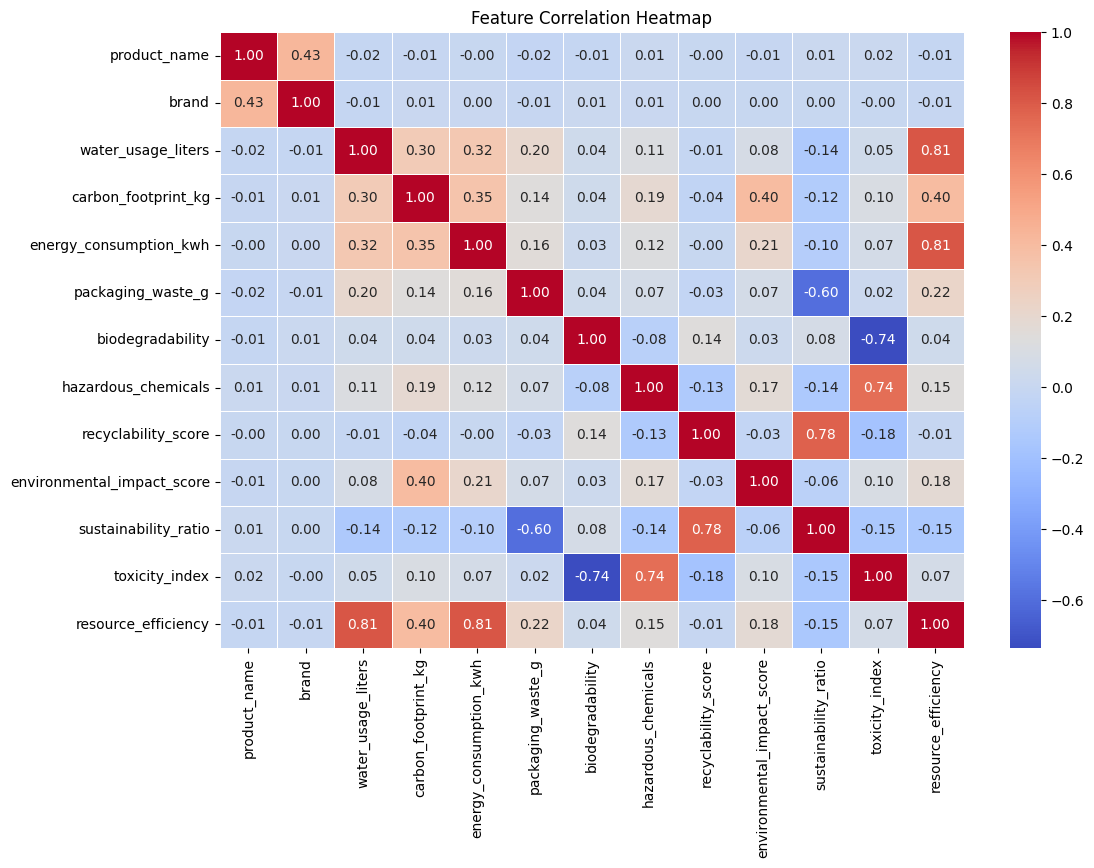

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Selected Features: ['carbon_footprint_kg', 'energy_consumption_kwh', 'resource_efficiency', 'water_usage_liters', 'toxicity_index', 'biodegradability', 'hazardous_chemicals', 'sustainability_ratio', 'recyclability_score']
Selected Features: ['carbon_footprint_kg', 'energy_consumption_kwh', 'resource_efficiency', 'water_usage_liters', 'toxicity_index', 'biodegradability', 'hazardous_chemicals', 'sustainability_ratio', 'packaging_waste_g', 'recyclability_score']


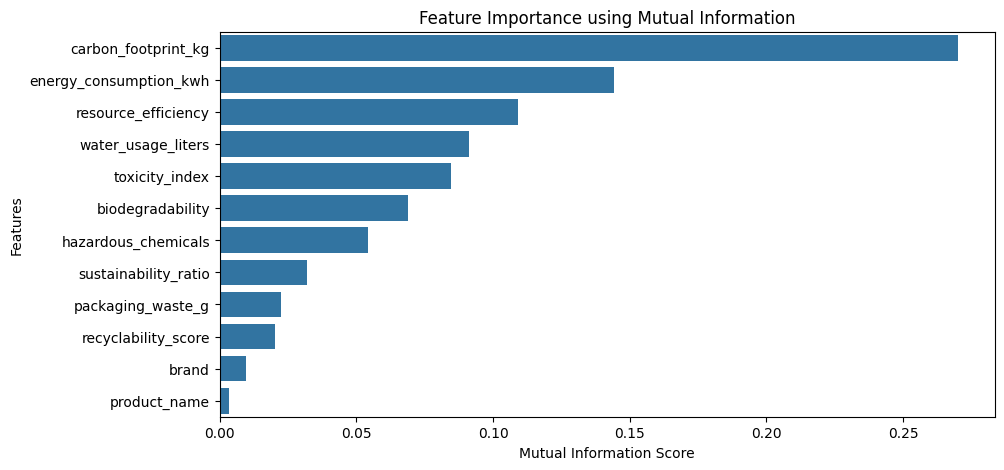

In [12]:
from sklearn.feature_selection import mutual_info_regression
# Define features and target
X = df.drop(columns=['environmental_impact_score'])  # Features
y = df['environmental_impact_score']

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select features with MI score above a threshold (e.g., 0.02)
selected_features = mi_scores[mi_scores > 0.02].index.tolist()
print("Selected Features:", selected_features)

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select features with MI score above a threshold (e.g., 0.02)
selected_features = mi_scores[mi_scores > 0.02].index.tolist()
print("Selected Features:", selected_features)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance using Mutual Information")
plt.show()

## Training the model

In [13]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [14]:
# Split data for model training
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

In [15]:

# Function to generate cross-validated predictions for base models
def get_oof_predictions(models, X_train, y_train, X_test, n_folds=5):
    # Initialize the numpy arrays we'll use for stacking
    train_stack = np.zeros((X_train.shape[0], len(models)))
    test_stack = np.zeros((X_test.shape[0], len(models)))
    test_pred = np.zeros((X_test.shape[0], n_folds, len(models)))
    
    # Create a KFold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Iterate through each model
    for m_idx, (model_name, model) in enumerate(models.items()):
        print(f"Getting OOF predictions for {model_name}")
        
        # Special handling for each fold rather than using cross_val_predict
        # This avoids using sklearn's internal API with XGBoost
        fold_preds = np.zeros(X_train.shape[0])
        
        # Loop through folds
        for f_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            # Get the training and validation data for this fold
            if isinstance(X_train, pd.DataFrame):
                fold_X_train, fold_X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            else:
                fold_X_train, fold_X_val = X_train[train_idx], X_train[val_idx]
                
            if isinstance(y_train, pd.Series):
                fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            else:
                fold_y_train, fold_y_val = y_train[train_idx], y_train[val_idx]
            
            # Clone the model (create a new instance with same parameters)
            if model_name in ['xgb', 'lgb']:
                clone_model = model.__class__(**model.get_params())
            else:
                from sklearn.base import clone
                clone_model = clone(model)
                
            # Train the model
            clone_model.fit(fold_X_train, fold_y_train)
            
            # Store predictions for validation data (for train stack)
            fold_preds[val_idx] = clone_model.predict(fold_X_val)
            
            # Predict on test data
            test_pred[:, f_idx, m_idx] = clone_model.predict(X_test)
        
        # Store the out-of-fold predictions for this model
        train_stack[:, m_idx] = fold_preds
        
        # Average test predictions across folds
        test_stack[:, m_idx] = test_pred[:, :, m_idx].mean(axis=1)
        
    return train_stack, test_stack

# Define base models
def get_base_models():
    models = {
        'rf': RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
        'xgb': xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, objective='reg:squarederror', 
                               random_state=42),
        'lgb': lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        'svr': SVR(kernel='rbf', C=1.0, epsilon=0.1),
        'knn': KNeighborsRegressor(n_neighbors=15),
        'ridge': Ridge(alpha=1.0, random_state=42),
        'elasticnet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
    }
    return models

# Generate stackable features using cross-validation
base_models = get_base_models()
train_stack, test_stack = get_oof_predictions(base_models, X_train, y_train, X_test, n_folds=5)

# Final fitting of base models on the entire training data
print("Fitting base models on full training data...")
final_base_models = {}
for model_name, model in base_models.items():
    print(f"Fitting {model_name}...")
    if model_name in ['xgb', 'lgb']:
        final_base_models[model_name] = model.__class__(**model.get_params())
    else:
        from sklearn.base import clone
        final_base_models[model_name] = clone(model)
    final_base_models[model_name].fit(X_train, y_train)

# Manual hyperparameter tuning for meta-model (avoiding GridSearchCV for XGBoost)
print("Tuning meta-model...")
meta_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

best_meta_score = float('-inf')
best_meta_params = {}
best_meta_model = None

# Perform manual grid search
for n_est in meta_param_grid['n_estimators']:
    for lr in meta_param_grid['learning_rate']:
        for depth in meta_param_grid['max_depth']:
            # Define a 5-fold cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = []
            
            # Perform cross-validation
            for train_idx, val_idx in kf.split(train_stack):
                # Get train/val split for this fold
                cv_X_train, cv_X_val = train_stack[train_idx], train_stack[val_idx]
                cv_y_train, cv_y_val = (y_train.iloc[train_idx] if isinstance(y_train, pd.Series) 
                                     else y_train[train_idx]), (y_train.iloc[val_idx] 
                                     if isinstance(y_train, pd.Series) else y_train[val_idx])
                
                # Train metamodel on this fold
                meta = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth,
                                        objective='reg:squarederror', random_state=42)
                meta.fit(cv_X_train, cv_y_train)
                
                # Evaluate
                preds = meta.predict(cv_X_val)
                score = -mean_squared_error(cv_y_val, preds)  # Negative MSE to maximize
                cv_scores.append(score)
            
            # Calculate average score across folds
            avg_score = np.mean(cv_scores)
            
            # Check if this is the best score
            if avg_score > best_meta_score:
                best_meta_score = avg_score
                best_meta_params = {'n_estimators': n_est, 'learning_rate': lr, 'max_depth': depth}

print(f"Best meta-model parameters: {best_meta_params}")

# Train final meta-model with best parameters
meta_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_meta_params)
meta_model.fit(train_stack, y_train)

# Make predictions with meta-model
stacked_pred = meta_model.predict(test_stack)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, stacked_pred))
r2 = r2_score(y_test, stacked_pred)
print(f'Stacking RMSE: {rmse:.4f}')
print(f'Stacking R² Score: {r2:.4f}')

# Also evaluate individual models for comparison
print("\nIndividual model performance:")
for model_name, model in final_base_models.items():
    pred = model.predict(X_test)
    model_rmse = np.sqrt(mean_squared_error(y_test, pred))
    model_r2 = r2_score(y_test, pred)
    print(f'{model_name} - RMSE: {model_rmse:.4f}, R²: {model_r2:.4f}')

# Check feature importances
print("\nMeta-model feature importances:")
for i, importance in enumerate(meta_model.feature_importances_):
    model_name = list(base_models.keys())[i]
    print(f"{model_name}: {importance:.4f}")

Getting OOF predictions for rf
Getting OOF predictions for xgb
Getting OOF predictions for lgb
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 10
[LightGBM] [Info] Start training from score -0.002834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 10
[LightGBM] [Info] Start training from score -0.005665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00035

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib

# Feature engineering
df['sustainability_ratio'] = (df['recyclability_score'] + 3) / (df['packaging_waste_g'] + 3)
df['toxicity_index'] = df['hazardous_chemicals'] - df['biodegradability']
df['resource_efficiency'] = (df['water_usage_liters'] + df['energy_consumption_kwh']) / 2

# Define features
numeric_features = [
    "water_usage_liters", "carbon_footprint_kg", "energy_consumption_kwh",
    "packaging_waste_g", "biodegradability", "hazardous_chemicals",
    "recyclability_score", "sustainability_ratio",
    "toxicity_index", "resource_efficiency", 
]
categorical_features = ["brand"]

# Prepare data
X = df[numeric_features + categorical_features]
y = df["environmental_impact_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor())
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Save the trained pipeline
joblib.dump(pipeline, "environmental_pipeline.pkl")



['environmental_pipeline.pkl']